In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt

from multiagent.environment import MultiAgentEnv
import multiagent.scenarios as scenarios

# load scenario from script
scenario_name = 'simple_tag'
scenario = scenarios.load(scenario_name + ".py").Scenario()
world = scenario.make_world()
env = MultiAgentEnv(world, scenario.reset_world, scenario.reward, scenario.observation)
print(env.n)
for i in range(env.n):
    print(env.action_space[i].n, env.observation_space[i].shape[0])

/Users/jiwoongpark/Documents/Python/MADDPG-pytorch/multiagent/__init__.py:23: UserWarning: This code base is no longer maintained, and is not expected to be maintained again in the future. 
For the past handful of years, these environments been maintained inside of PettingZoo (see https://pettingzoo.farama.org/environments/mpe/). 
This maintained version includes documentation, support for the PettingZoo API, support for current versions of Python, numerous bug fixes, 
support for installation via pip, and numerous other large quality of life improvements. 
We encourage researchers to switch to this maintained version for all purposes other than comparing to results run on this version of the environments. 

  warnings.warn("This code base is no longer maintained, and is not expected to be maintained again in the future. \n"


4
5 16
5 16
5 16
5 14


In [2]:
obs_shapes = [env.observation_space[i].shape for i in range(env.n)] # env.n == 4
actions_shape_n = [env.action_space[i].n for i in range(env.n)]
actions_n = 0
obs_shape_n = 0
for actions in actions_shape_n:
    actions_n += actions
for obs_shape in obs_shapes:
    obs_shape_n += obs_shape[0]
print(actions_n, obs_shape_n) # sum of action space

20 62


In [3]:
import agent
import ddpg
device = 'cpu'
max_episode = 10000
gamma = 0.95
tau = 0.01
batch_size = 1024

workers = []
for i in range(4):
    print(env.action_space[i].n, env.observation_space[i].shape[0])
    action_space_n = env.action_space[i].n
    observation_space_n = env.observation_space[i].shape[0]
    
    critic = agent.Critic(obs_shape_n, actions_n).to(device) #Centralized
    actor = agent.Actor(observation_space_n, action_space_n).to(device) #Decentrialized
    target_critic = agent.Critic(obs_shape_n, actions_n, tau).to(device) #Centralized
    target_actor = agent.Actor(observation_space_n, action_space_n, tau).to(device) #Decentrialized
    actor.eval()
    critic.eval()
    target_actor.eval()
    target_critic.eval()

    ddpg_algo = ddpg.DDPG(i, actor, critic, target_actor, target_critic, gamma, batch_size,train_mode=True, discrete_action=True, alg_mode='MADDPG')
    workers.append(ddpg_algo)

5 16
5 16
5 16
5 14


/Users/jiwoongpark/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import time
render = False
total_steps = 0
reward_history = []
for episode in range(max_episode):
    obs = env.reset()
    terminal = False
    ep_ave_max_q_value = [0 for _ in range(len(workers))]
    network_update = False
    for worker in workers:
        worker.ou.reset() # OrnsteinUhlenbeckActionNoise
            
    total_reward = [0 for i in range(len(workers))]
    step = 0
    while not terminal and step < 25:
        if render:
            env.render()
            time.sleep(0.03)

        actions = []
        for i, worker in enumerate(workers):
            action = worker.act(obs[i], explore=False)
            actions.append(action)
        obs2, reward, done, _ = env.step(actions)
        for i, rew in enumerate(reward):
            total_reward[i] += rew
            
        total_steps += 1
        for i, worker in enumerate(workers):
            worker.add(actions[i], [reward[i]], obs[i], obs2[i], [done[i]])
    
        if step % 100 == 0:
            network_update = True
            update_target = False
            for i, worker in enumerate(workers):
                ep_avg_max_q, update_target = worker.train(workers)
                ep_ave_max_q_value[i] += ep_avg_max_q
            if update_target:
                for i, worker in enumerate(workers):
                    worker.update_targets()
        
        obs = obs2
        step += 1

    print(episode, 'Reward:', total_reward)
    reward_history.append(total_reward)
env.close()

0 Reward: [0, 0, 0, -147.19768169003558]
1 Reward: [0, 0, 0, -145.37285289124964]
2 Reward: [30, 30, 30, -155.9159684480202]
3 Reward: [10, 10, 10, -122.6084716687921]
4 Reward: [0, 0, 0, -9.528809916118838]
5 Reward: [0, 0, 0, -118.07251677027844]
6 Reward: [0, 0, 0, -123.78374355479306]
7 Reward: [0, 0, 0, -97.20084546464545]
8 Reward: [0, 0, 0, -11.788562059767674]
9 Reward: [0, 0, 0, -23.475880400726346]
10 Reward: [10, 10, 10, -92.93344765732759]
11 Reward: [0, 0, 0, -113.01537581608426]
12 Reward: [0, 0, 0, -95.62560968455928]
13 Reward: [0, 0, 0, -38.75937732908055]
14 Reward: [0, 0, 0, -114.12657967933504]
15 Reward: [10, 10, 10, -70.25374925716325]
16 Reward: [0, 0, 0, -51.358054620603]
17 Reward: [0, 0, 0, -178.18752949029917]
18 Reward: [0, 0, 0, -183.50943873637857]
19 Reward: [10, 10, 10, -60.909084095371625]
20 Reward: [0, 0, 0, -128.96007915641275]
21 Reward: [0, 0, 0, -32.276099628964445]
22 Reward: [10, 10, 10, -65.7682164658173]
23 Reward: [0, 0, 0, -110.5273868960209

/Users/jiwoongpark/Documents/Python/MADDPG-pytorch/agent.py:117: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.parameters(), 0.5)
/Users/jiwoongpark/Documents/Python/MADDPG-pytorch/agent.py:63: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.parameters(), 0.5)


42 Reward: [0, 0, 0, -86.35669456174321]
43 Reward: [0, 0, 0, -129.42384742223499]
44 Reward: [0, 0, 0, -20.155428969386136]
45 Reward: [0, 0, 0, -149.9652958159148]
46 Reward: [0, 0, 0, -64.42462245750491]
47 Reward: [0, 0, 0, -161.32520467465685]
48 Reward: [0, 0, 0, -179.4710236710751]
49 Reward: [0, 0, 0, -138.20840646300815]
50 Reward: [0, 0, 0, -175.856180310457]
51 Reward: [0, 0, 0, -162.44544634939535]
52 Reward: [0, 0, 0, -16.19576626899274]
53 Reward: [0, 0, 0, -34.588473998513436]
54 Reward: [10, 10, 10, -104.04360021455503]
55 Reward: [0, 0, 0, -179.70386657886786]
56 Reward: [0, 0, 0, -184.93532538576923]
57 Reward: [40, 40, 40, -98.0933491573385]
58 Reward: [0, 0, 0, -64.72612064577737]
59 Reward: [0, 0, 0, -89.42757594347158]
60 Reward: [0, 0, 0, -48.3130675365261]
61 Reward: [0, 0, 0, -170.45920208854687]
62 Reward: [0, 0, 0, -128.64305249481544]
63 Reward: [0, 0, 0, -187.78285266436154]
64 Reward: [0, 0, 0, -97.26050509123311]
65 Reward: [0, 0, 0, -109.25770712972]
66 

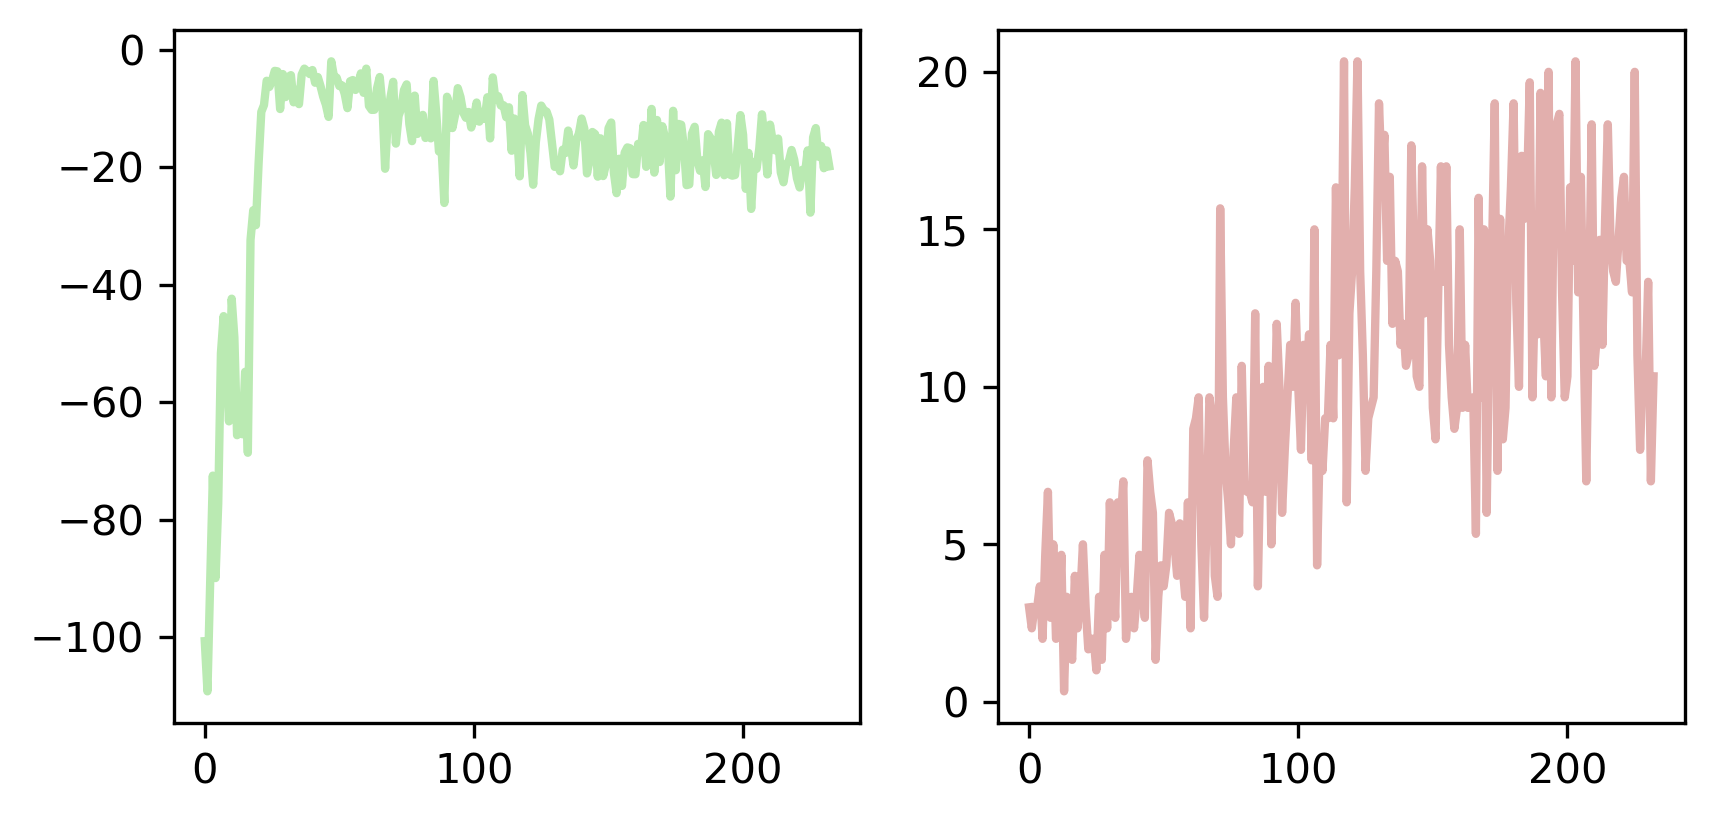

In [27]:
reward_history = np.array(reward_history)

bin_size = 30
fig, axes = plt.subplots(1,2,figsize=(6.5,3), dpi=300)
axes[0].plot([np.mean(reward_history[i*bin_size:(i+1)*bin_size, -1]) for i in range(max_episode//bin_size)][:int(7000/bin_size)],
             c='#baeab2', lw=2)
axes[1].plot([np.mean(reward_history[i*bin_size:(i+1)*bin_size, 0]) for i in range(max_episode//bin_size)][:int(7000/bin_size)],
             c='#e2afad', lw=2)


In [13]:
reward_history.shape

(10000, 4)